In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [17]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots
using LaTeXStrings

### Simple twin-experiment

In [19]:
# Define parameters
Ne = 100
Nx = 3
Ny = 3
Δtdyn = 0.05
Δtobs = 0.1

σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
t0 = 0.0
tf = 600.0
Tf = ceil(Int64, tf/Δtobs)

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz63!
h(t,x) = x

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, f, h);

In [20]:
# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

# Run dynamics and generate data
data = generate_lorenz63(model, x0, Tf);

In [21]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)

Stochastic EnKF  with filtered = false


In [22]:
statehist = seqassim(dyn, data, Tf, model.ϵx, enkf, X, model.Ny, model.Nx, t0);

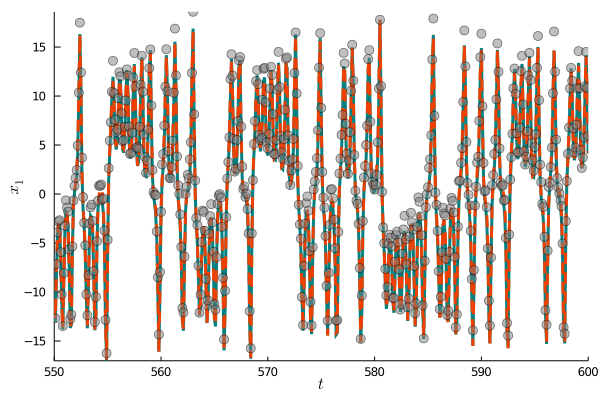

In [24]:
# Plot the first component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1", legend = false)
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal)
plot!(plt, data.tt[nb:Δ:ne], mean_hist(statehist)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3)
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5)
plt

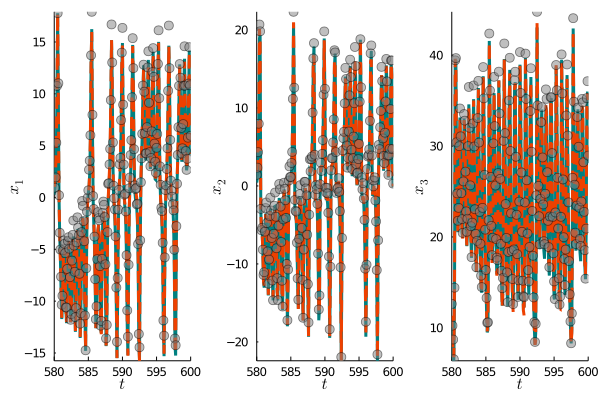

In [30]:
# Plot the different component of the state over time
nb = 5800
ne = 6000
Δ = 1
plt = plot(layout = grid(1,3), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", legend = false)

for i =1:3
    plot!(plt[1,i], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, ylabel = latexstring("x_"*string(i)))
    plot!(plt[1,i], data.tt[nb:Δ:ne], mean_hist(statehist)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
         color = :orangered2, linestyle = :dash, markersize = 3)
    scatter!(plt[1,i], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5)
end

plt

### Benchmark of the EnKF filter

In [33]:
path = "/media/mat/HDD/AdaptiveTransportMap/src/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 0.6146538123085485
Ne 20 RMSE: 0.5044150066371673
Ne 40 RMSE: 0.41419645168767877
Ne 60 RMSE: 0.42264940344732227
Ne 100 RMSE: 0.41777918173246237
Ne 200 RMSE: 0.4295373605255836
 19.730120 seconds (68.89 M allocations: 6.501 GiB, 7.78% gc time)


In [34]:
metric_list = benchmark_lorenz63(model, data, path, [200], [1.01])

(Ne, β) = (200, 1.01)
 11.899206 seconds (62.75 M allocations: 5.935 GiB, 10.27% gc time)
Ne = 200
Ne 200& β 1.01 RMSE: 0.40515249131046144


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.03315365807936676, 0.13035816107622553, 0.15575938995361735, 0.08285414691192579, 0.10279903164895307, 0.10085532372477746, 0.040715978881467066, 0.02344526651568663, 0.13001291285410724, 0.060222924716812606  …  0.336046600985711, 0.3219616094228554, 0.27914049087242476, 0.21808549443308897, 0.11719188457125905, 0.06514924813870608, 0.044631869227786856, 0.09320880705958097, 0.48513230762792214, 0.5359435877096703], 0.26072538907807874, 0.40515249131046144, 0.3809523301465489, [0.30463891037234103, 0.4039956257372557, 0.5392376788574897, 0.561329240636918, 0.44631601609544314, 0.3705780961387149, 0.2860154066776007, 0.30464694614417753, 0.4447491044330345, 0.6020438897871416  …  0.6735267028114135, 0.8825914849061818, 0.9292150193836008, 0.7373040993590383, 0.5453312330694775, 0.393004885309664, 0.38051122108090574, 0.5190094353126404, 0.7418009724191931, 1.0182073600746218], 0.5437461078374204, 0.5969930029675979, 0.23528935951268667, 